# Figure 6:  SMYLE & DPLE Global Sea Level Pressure ACC Maps

In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io
from SMYLEutils import regrid_utils as regrid

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data I/O using Dask

### Create Dask Cluster

In [87]:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

In [5]:
cluster

### Read in CAM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [6]:
# This preprocessor will return a seasonal mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    ds0 = cal.time_set_mid(ds0,'time')
    d0 = ds0[field].isel(time=slice(1, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = cal.mon_to_seas(d0)
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.to_dataset(name=field)
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    return d0

In [7]:
%%time
# SMYLE-NOV SLP data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
smyle11_seas = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle11_seas.nbytes/1e9 #GB

CPU times: user 41.2 s, sys: 19.2 s, total: 1min
Wall time: 1min 25s


3.468172712

In [8]:
%%time
# SMYLE-FEB PSL data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 2
smyle02_seas = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle02_seas.nbytes/1e9 #GB

CPU times: user 43.2 s, sys: 19.5 s, total: 1min 2s
Wall time: 1min 24s


3.468172712

In [9]:
%%time
# SMYLE-MAY PSL data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 5
smyle05_seas = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle05_seas.nbytes/1e9 #GB

CPU times: user 42.3 s, sys: 19.2 s, total: 1min 1s
Wall time: 1min 22s


3.468172712

In [10]:
%%time
# SMYLE-AUG PSL data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 8
smyle08_seas = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle08_seas.nbytes/1e9 #GB

CPU times: user 43.7 s, sys: 19 s, total: 1min 2s
Wall time: 1min 25s


3.468172712

In [11]:
%%time
# DPLE-NOV PSL data
# process all 40 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/atm/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+field+'/'+casename+filetype+field+'.*.nc'
ens = 40
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
dple11_seas = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
dple11_seas.nbytes/1e9 #GB

CPU times: user 25.2 s, sys: 3.05 s, total: 28.2 s
Wall time: 33.6 s


6.79478016

### Regrid Hindcast data

In [12]:
## Define 5x5 destgrid
destgrid = xr.Dataset({'lat':np.arange(-90,95,5),'lon':np.arange(0,360,5)})
ny = destgrid.sizes['lat']
nx = destgrid.sizes['lon']
destgrid['mask'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})
rEarth = 6378.1
destgrid['area'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})*np.cos(np.deg2rad(destgrid.lat))*rEarth**2
destgrid['lat'] = destgrid['lat'].assign_attrs({'units':'degrees_north','long_name':'latitude'})
destgrid['lon'] = destgrid['lon'].assign_attrs({'units':'degrees_east','long_name':'longitude'})
destgrid = regrid.add_grid_bounds(destgrid)

In [13]:
dple11_seas = regrid.add_grid_bounds(dple11_seas)
smyle11_seas = regrid.add_grid_bounds(smyle11_seas)
smyle02_seas = regrid.add_grid_bounds(smyle02_seas)
smyle05_seas = regrid.add_grid_bounds(smyle05_seas)
smyle08_seas = regrid.add_grid_bounds(smyle08_seas)

In [14]:
## Create regridder from CAM-FV1deg to destgrid
regrid_cam1deg = xe.Regridder(dple11_seas, destgrid, 'conservative', periodic=True)

In [15]:
%%time
dple11_da = regrid_cam1deg(dple11_seas.PSL).load()

CPU times: user 2min 17s, sys: 3.03 s, total: 2min 20s
Wall time: 2min 25s


In [16]:
%%time
smyle11_da = regrid_cam1deg(smyle11_seas.PSL).load()

CPU times: user 1min 17s, sys: 1.32 s, total: 1min 19s
Wall time: 1min 21s


In [17]:
%%time
smyle02_da = regrid_cam1deg(smyle02_seas.PSL).load()

CPU times: user 1min 11s, sys: 1.27 s, total: 1min 12s
Wall time: 1min 16s


In [18]:
%%time
smyle05_da = regrid_cam1deg(smyle05_seas.PSL).load()

CPU times: user 1min 13s, sys: 1.3 s, total: 1min 14s
Wall time: 1min 17s


In [19]:
%%time
smyle08_da = regrid_cam1deg(smyle08_seas.PSL).load()

CPU times: user 1min 13s, sys: 1.33 s, total: 1min 15s
Wall time: 1min 17s


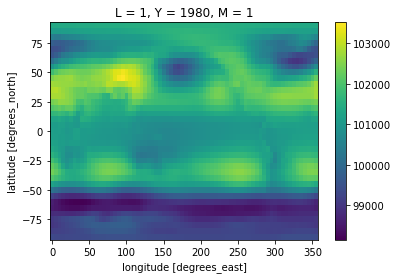

In [20]:
smyle11_da.isel(Y=10,L=0,M=0).plot();

In [24]:
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
ds1 = dple11_da.rename('PSL').to_dataset()
ds1['time'] = dple11_seas.time
ds1.to_netcdf(outdir+'DPLE11_PSL_seas_5x5.nc')

ds1 = smyle11_da.rename('PSL').to_dataset()
ds1['time'] = smyle11_seas.time
ds1.to_netcdf(outdir+'SMYLE11_PSL_seas_5x5.nc')

ds1 = smyle02_da.rename('PSL').to_dataset()
ds1['time'] = smyle02_seas.time
ds1.to_netcdf(outdir+'SMYLE02_PSL_seas_5x5.nc')

ds1 = smyle05_da.rename('PSL').to_dataset()
ds1['time'] = smyle05_seas.time
ds1.to_netcdf(outdir+'SMYLE05_PSL_seas_5x5.nc')

ds1 = smyle08_da.rename('PSL').to_dataset()
ds1['time'] = smyle08_seas.time
ds1.to_netcdf(outdir+'SMYLE08_PSL_seas_5x5.nc')

In [3]:
## Retrieve PSL-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
dple11_da = xr.open_dataset(outdir+'DPLE11_PSL_seas.nc')['PSL']
smyle11_da = xr.open_dataset(outdir+'SMYLE11_PSL_seas.nc')['PSL']
smyle02_da = xr.open_dataset(outdir+'SMYLE02_PSL_seas.nc')['PSL']
smyle05_da = xr.open_dataset(outdir+'SMYLE05_PSL_seas.nc')['PSL']
smyle08_da = xr.open_dataset(outdir+'SMYLE08_PSL_seas.nc')['PSL']

### Get SLP OBS

In [38]:
# ERA5  (already on CAM grid)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_era5 = xr.open_dataset(obs_dir+'mon/SLP/SLP_ERA5_oncamgrid_1950_2020.nc',decode_times=False)
era5_montime_vals = [cftime.DatetimeNoLeap(1950+year, 1+month, 15) for year in range(71) for month in range(12)]
ds_era5['time'] = era5_montime_vals
ds_era5 = ds_era5.sel(time=slice("1960","2020"))

### Compute OBS seasonal averages

In [39]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [40]:
era5_seas = obs_convert_mon_to_seas(ds_era5.slp,'PSL').sel(year=slice("1960","2020"))
era5_seas = regrid.add_grid_bounds(era5_seas)

In [41]:
era5_seas['lat'] = era5_seas['lat'].assign_attrs({'long_name':'latitude'})
era5_seas['lon'] = era5_seas['lon'].assign_attrs({'long_name':'longitude'})

### Regrid OBS

In [42]:
%%time
regrid_era = xe.Regridder(era5_seas, destgrid, 'conservative', periodic=True)
era5_seas_rg = regrid_era(era5_seas.PSL,skipna=True, na_thres=0.9)

CPU times: user 1.42 s, sys: 54.7 ms, total: 1.48 s
Wall time: 1.53 s


In [47]:
## convert OBS to anomalies from 1972-2017
era5 = era5_seas_rg - era5_seas_rg.sel(year=slice(1972,2017)).mean('year')

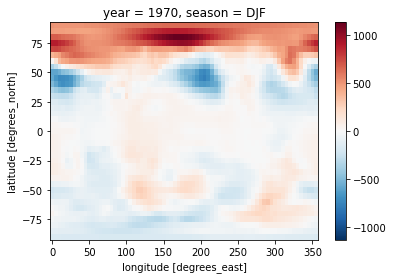

In [48]:
era5.isel(year=10,season=0).plot();

# Anomaly Correlation Plots

In [45]:
%%time
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(smyle11_da,smyle11_seas.time,1972,2017)
dple11_anom,dple11_clim = stat.remove_drift(dple11_da,dple11_seas.time,1972,2017)
smyle02_anom,smyle02_clim = stat.remove_drift(smyle02_da,smyle02_seas.time,1972,2017)
smyle05_anom,smyle05_clim = stat.remove_drift(smyle05_da,smyle05_seas.time,1972,2017)
smyle08_anom,smyle08_clim = stat.remove_drift(smyle08_da,smyle08_seas.time,1972,2017)

CPU times: user 942 ms, sys: 612 ms, total: 1.55 s
Wall time: 1.59 s


In [46]:
# Skill Score Functions
import xskillscore as xs

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

def leadtime_corr_byseas(mod_da,mod_time,obs_da,detrend=False):
    """ 
    Computes the correlation coefficient between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a seasonally-averaged hindcast DataArray dimensioned (Y,L,M,...)
        obs_da: an OBS DataArray dimensioned (time,...)
        mod_time: a hindcast time DataArray dimensioned (Y,L). NOTE: assumes mod_time.dt.month
            returns mid-month of 3-month seasonal average (e.g., mon=1 ==> "DJF").
    """
    ens = mod_da.mean('M')
    seasons = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
    r_list = []
    p_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_ts = obs_da.sel(season=seasons[ens_time_month]).rename({'year':'time'})
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval})

In [49]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom,smyle11_seas.time,era5)
dple11_corr = leadtime_corr_byseas(dple11_anom,dple11_seas.time,era5)
smyle02_corr = leadtime_corr_byseas(smyle02_anom,smyle02_seas.time,era5)
smyle05_corr = leadtime_corr_byseas(smyle05_anom,smyle05_seas.time,era5)
smyle08_corr = leadtime_corr_byseas(smyle08_anom,smyle08_seas.time,era5)

CPU times: user 1.18 s, sys: 206 ms, total: 1.39 s
Wall time: 1.46 s


CPU times: user 10.2 s, sys: 23 ms, total: 10.2 s
Wall time: 10.4 s


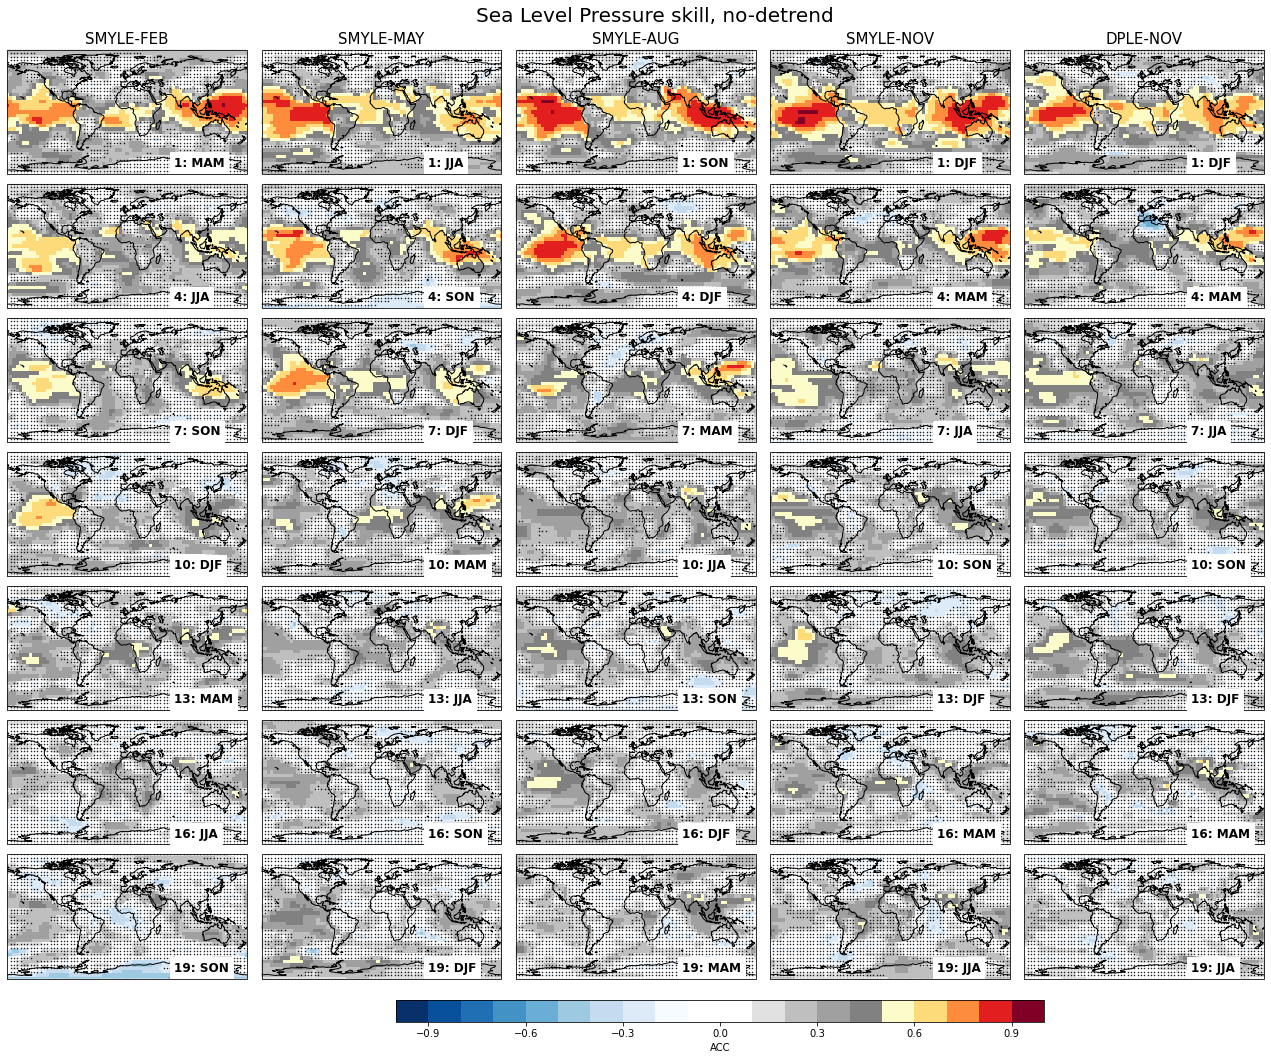

In [78]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax1, smyle02_corr.pval.isel(L=i), smyle02_corr.lon, smyle02_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax2, smyle05_corr.pval.isel(L=i), smyle05_corr.lon, smyle05_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax3, smyle08_corr.pval.isel(L=i), smyle08_corr.lon, smyle08_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax4, smyle11_corr.pval.isel(L=i), smyle11_corr.lon, smyle11_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax5, dple11_corr.pval.isel(L=i), dple11_corr.lon, dple11_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')


fig.suptitle('Sea Level Pressure skill, no-detrend',fontsize=20)
fig.subplots_adjust(hspace=0.08, wspace=0.06)
fig.subplots_adjust(left=0,right=0.97,bottom=0.08,top=0.94)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('Fig06_SLP_ACC_nodetrend.png')

### Test Significance Hatching using correlation p-values

CPU times: user 275 ms, sys: 7.98 ms, total: 283 ms
Wall time: 284 ms


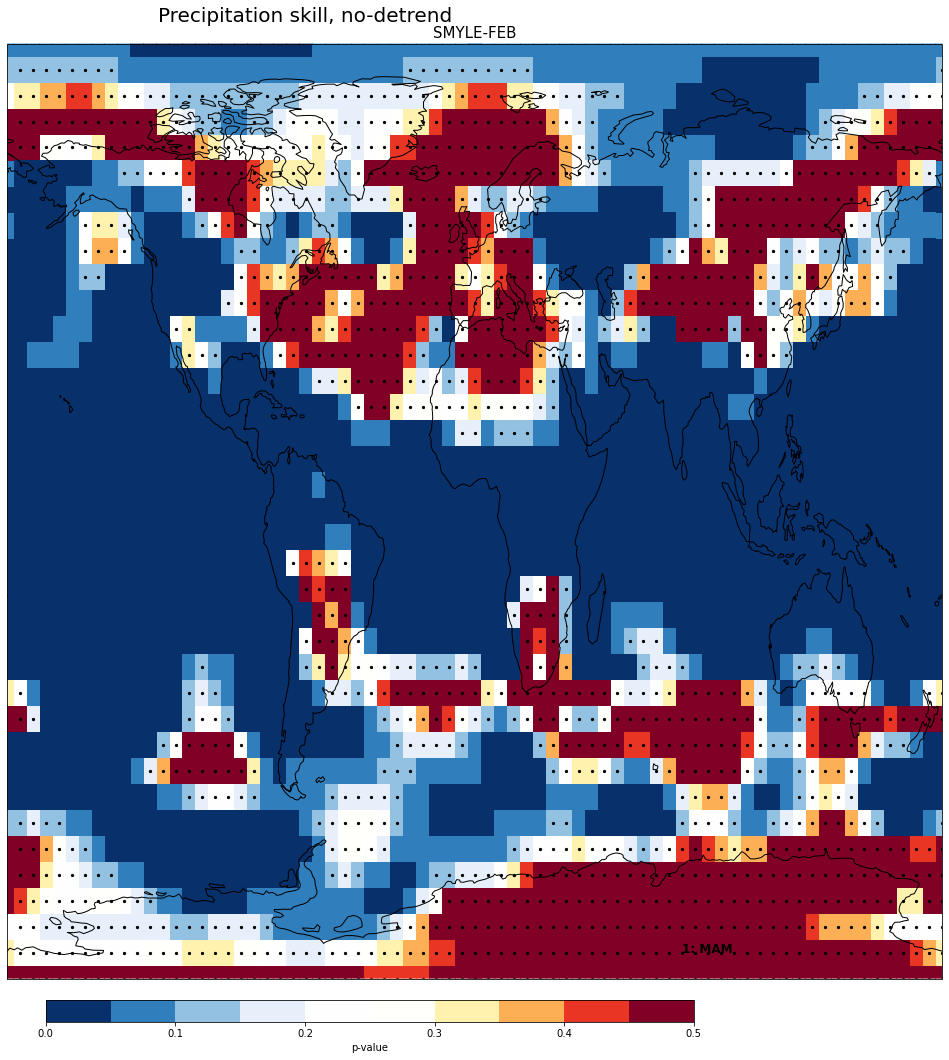

In [79]:
%%time
ci = 0.05
cmin = 0.0
cmax = 0.5
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=1
ncols=1

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = str(i+1)+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_corr.pval.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj)
    maps.map_pvalsig_global_subplot(ax1, smyle02_corr.pval.isel(L=i), smyle02_corr.lon, smyle02_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=20,marker=".")
    ldstr = str(i+1) + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(80.,-85,ldstr,fontsize=fsize,fontweight=fweight)



fig.suptitle('Precipitation skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='p-value', orientation='horizontal')

### Use Linear Detrending

In [80]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom,smyle11_seas.time,era5,detrend=True)
dple11_corr = leadtime_corr_byseas(dple11_anom,dple11_seas.time,era5,detrend=True)
smyle02_corr = leadtime_corr_byseas(smyle02_anom,smyle02_seas.time,era5,detrend=True)
smyle05_corr = leadtime_corr_byseas(smyle05_anom,smyle05_seas.time,era5,detrend=True)
smyle08_corr = leadtime_corr_byseas(smyle08_anom,smyle08_seas.time,era5,detrend=True)

CPU times: user 1.8 s, sys: 215 ms, total: 2.02 s
Wall time: 2.25 s


CPU times: user 9.86 s, sys: 22.5 ms, total: 9.88 s
Wall time: 10.1 s


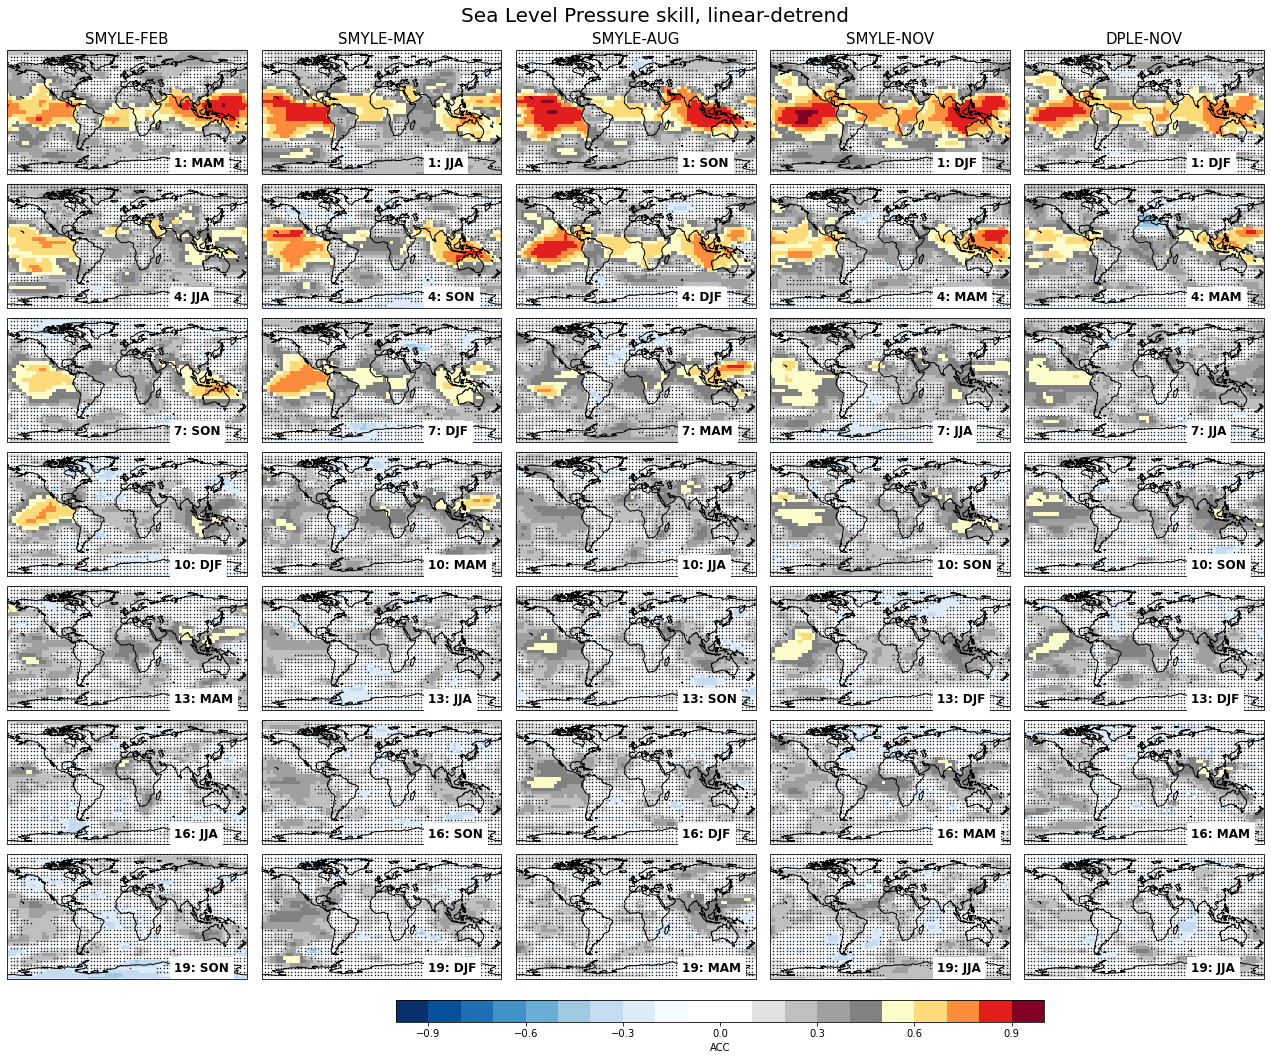

In [81]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax1, smyle02_corr.pval.isel(L=i), smyle02_corr.lon, smyle02_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax2, smyle05_corr.pval.isel(L=i), smyle05_corr.lon, smyle05_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax3, smyle08_corr.pval.isel(L=i), smyle08_corr.lon, smyle08_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax4, smyle11_corr.pval.isel(L=i), smyle11_corr.lon, smyle11_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax5, dple11_corr.pval.isel(L=i), dple11_corr.lon, dple11_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')


fig.suptitle('Sea Level Pressure skill, linear-detrend',fontsize=20)
fig.subplots_adjust(hspace=0.08, wspace=0.06)
fig.subplots_adjust(left=0,right=0.97,bottom=0.08,top=0.94)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('Fig06_SLP_ACC_lineardetrend.png')

### Look at subsampled skill maps

In [82]:
# This is a list of years for which observed Nino3.4 DJF standardized anomalies exceed +/- 1 std dev. See
# SMYLE-analysis/notebooks/PaperFigs/SMYLEvsDPLE_GlobMaps_SAT.ipynb.
keepyears = np.array([1971, 1973, 1974, 1976, 1983, 1987, 1989, 1992, 1995, 1998, 1999, 2000, 2008, 2010, 2011, 2016])

In [83]:
def leadtime_corr_byseas_subsamp(mod_da,mod_time,obs_da,keep,detrend=False):
    """ 
    Computes the correlation coefficient between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a seasonally-averaged hindcast DataArray dimensioned (Y,L,M,...)
        obs_da: an OBS DataArray dimensioned (time,...)
        mod_time: a hindcast time DataArray dimensioned (Y,L). NOTE: assumes mod_time.dt.month
            returns mid-month of 3-month seasonal average (e.g., mon=1 ==> "DJF").
    """
    ens = mod_da.mean('M').sel(Y=keep)
    mod_time = mod_time.sel(Y=keep)
    seasons = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
    r_list = []
    p_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        verify_year = mod_time.sel(L=i).dt.year.data
        verify_month = mod_time.sel(L=i).dt.month.data[0]
        obs_ts = obs_da.sel(season=seasons[verify_month]).rename({'year':'time'})
        ens_ts = ens_ts.assign_coords(time=("time",verify_year))
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval})

In [85]:
%%time
keep11 = (keepyears-1)
keep02 = keepyears
keep05 = keepyears
keep08 = (keepyears-1)
smyle11_corr = leadtime_corr_byseas_subsamp(smyle11_anom,smyle11_seas.time,era5,keep11,detrend=True)
dple11_corr = leadtime_corr_byseas_subsamp(dple11_anom,dple11_seas.time,era5,keep11,detrend=True)
smyle02_corr = leadtime_corr_byseas_subsamp(smyle02_anom,smyle02_seas.time,era5,keep02,detrend=True)
smyle05_corr = leadtime_corr_byseas_subsamp(smyle05_anom,smyle05_seas.time,era5,keep05,detrend=True)
smyle08_corr = leadtime_corr_byseas_subsamp(smyle08_anom,smyle08_seas.time,era5,keep08,detrend=True)

CPU times: user 1.65 s, sys: 209 ms, total: 1.86 s
Wall time: 1.89 s


CPU times: user 10.3 s, sys: 22.4 ms, total: 10.4 s
Wall time: 10.6 s


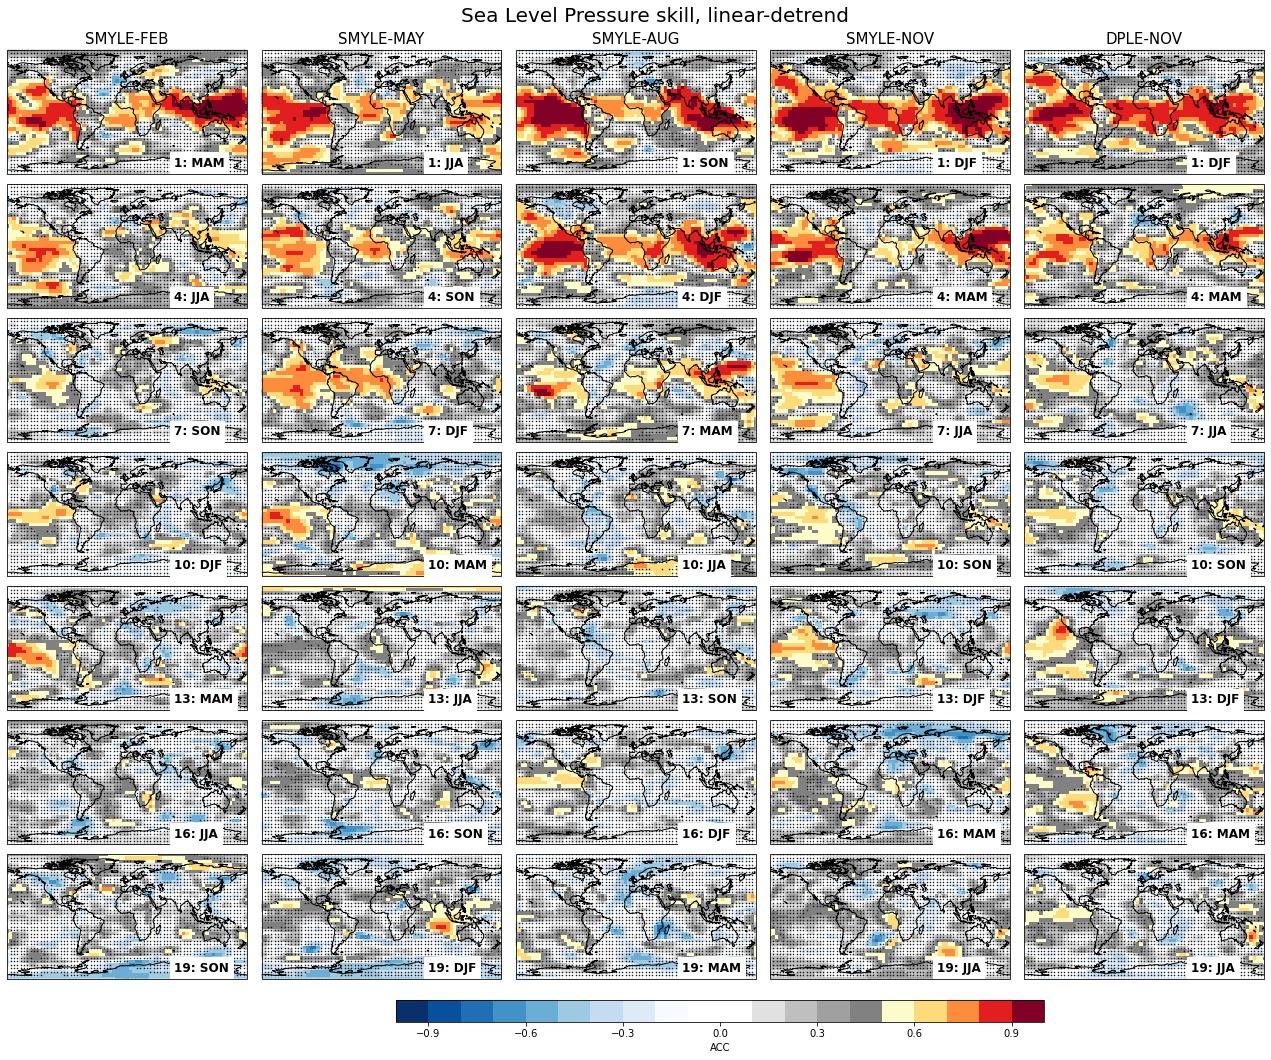

In [86]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax1, smyle02_corr.pval.isel(L=i), smyle02_corr.lon, smyle02_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax2, smyle05_corr.pval.isel(L=i), smyle05_corr.lon, smyle05_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax3, smyle08_corr.pval.isel(L=i), smyle08_corr.lon, smyle08_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax4, smyle11_corr.pval.isel(L=i), smyle11_corr.lon, smyle11_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax5, dple11_corr.pval.isel(L=i), dple11_corr.lon, dple11_corr.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')


fig.suptitle('Sea Level Pressure skill, linear-detrend',fontsize=20)
fig.subplots_adjust(hspace=0.08, wspace=0.06)
fig.subplots_adjust(left=0,right=0.97,bottom=0.08,top=0.94)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('Fig06_SLP_ACC_lineardetrend_subsamp.png')